In [2]:
from tbparse import SummaryReader
import torch
# import required module
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from tqdm import tqdm


# Clinical Prompt Learning
This notebook is dedicated to the development and application of prompt learning methods to clinically meaningful classification or predictive tasks. We present results across multiple clinical tasks using the Mimic-III free text data and compare traditional finetuning via a classification head on top of a Pretrained Language Model (PLM) against several prompt learning approaches. 

## Prompt learning
Prompt learning is the latest trend in the field of Natural Language Processing (NLP) and large PLMs with some interesting results on many standard NLP benchmark datasets [cite]. 

# TODO:

- [x] Function to extract the best performing run for each model setup i.e. the best prompt-model for each training size
- [x] Implement function to inject the trainable parameters for sensitivity analysis into the dataframes created by the TB_DataProcessor class. Have to hard code these


In [13]:

class TB_DataProcessor:
    
    '''
    Class to handle the tensorboard events files produced by this repos experiments. Its rather big and ugly, but gets the job done.
    
    
    '''
    def __init__(self,log_dirs, results_dir = "./results/"):
        # set the log dir 
        self.log_dirs = log_dirs

        # set the dir to save anything that gets saved e.g. figures and csv files
        self.results_dir = results_dir
        # and quickly make sure it exists and make it if not
        if not os.path.exists(self.results_dir):
            print(f"Anything you want saved will go here: {self.results_dir}")
            os.makedirs(self.results_dir)

        # lets make a figures and tables folder in there
        self.figures_dir = f"{self.results_dir}/figures/"
        if not os.path.exists(self.figures_dir):
            print(f"Any figures saved will go in: {self.figures_dir}")
            os.makedirs(self.figures_dir)

        # tables/csvs
        self.tables_dir = f"{self.results_dir}/tables/"
        if not os.path.exists(self.tables_dir):
            print(f"Any figures saved will go in: {self.tables_dir}")
            os.makedirs(self.tables_dir)

        # create a dictionary lookup for number of trainable parameters for both prompt and plm+classifier models
        # for classifier in the plm+classification_head model this is the classifier_hidden_dim:number of trainable parameters
        self.classifier_trainable_params_lookup = {
                                            2: 1559,
                                            5: 3887, 
                                            10: 7767, 
                                            100: 77607,
                                            768: 595975,
                                            807: 626239,
                                            2000: 1552007                                                
                                            }

        # in the prompt learning setting this will be based on the mixed template and the verbalizer - although soft verbalizer is fixed at 626500
        # So perhaps we want to just look at the manual verbalizer setting. But then mixed template is difficult to scale sensibly.
        # here we use the template_id for icd9 mixed template script to derive the number of trainable parameters. I.e. number of tunable soft tokens * 768 is the formula.
        self.prompt_trainable_params_lookup = {0:1536,
                                         1: 3840,
                                         2: 3072,
                                         3: 9984,
                                         4: 1536
                                        }
        
        # concatenate all the log files in the directory 
        self.all_logs, self.sensitivity_logs, self.optimized_logs = self.concatenate_all_logs(self.log_dirs)       
        sns.set(font_scale=1.05)

                
        plt.rcParams["figure.figsize"] = [8, 6]
        plt.rcParams["figure.autolayout"] = True   
        # plt.rcParams.update({'font.family':'Times New Roman'})
        plt.rcParams.update({'font.family':'fantasy'})

        # sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'black'})
        sns.set_style("whitegrid", {'axes.grid' : False})
    
    def concatenate_all_logs(self, log_dirs):
        
        '''
        Function to read in, organise and augment tensorboard events files by dynamically reading in and 
        adding variables best on filenames - as per the setup of the training
        
        
        '''
       
        print("concatenating all log files!")
        
        # we will potentially have mutiple log dirs provided in a list - so will iterate over them
        # empy list to fill
        combined_log_dfs = []
        
        # we will have some sensitivity analysis experiments we want to keep separate
        combined_sens_log_dfs = []
        # we also have a separate optimized triage study after hyperparam search
        combined_opt_logs = []
        for log_dir in log_dirs:
            print(f"working on following log directory: {log_dir}")
            
            # all experiment run dfs
            dfs = []
            # sensitivity analysis runs
            sens_dfs = []   
            # optimised experiment runs
            opt_dfs = []         

            # that directory
            for root, dirs, files in tqdm(os.walk(log_dir), desc = "Finding logs!"):            
                for filename in files:                
                    full_path = os.path.join(root, filename)                 

                    # the file name for tensorboard logs is horrible so just regex for tfevents
                    if "tfevents" in full_path:
                        
                        # bit crude but we have a separate set of sensitivity analyses that we want to keep as a separate df
                        if "sensitivity" in full_path:
                            print("we got the sensitivity analyses here!")
                            # now parse the tensorboard summary data
                            reader = SummaryReader(full_path)
                            sens_df = reader.scalars

                            # get the model paramters based on filename

                            # now add the training type e.g. prompt learning or traditional
                            # print("full path is: ", full_path)                       
                            # print("full path split is: ", full_path.split("/"))
                            
                            # can also pull the dataset/task name from the filepath
            
                            if full_path.split("/")[1] == "prompt-based-models":
                                sens_df['paradigm'] = "prompt learning"
                            elif full_path.split("/")[1] == "pytorch-lightning-models":                            
                                sens_df["paradigm"] = "traditional fine-tuning"                            

                            sens_df["task"] = full_path.split("/")[4]
                            sens_df["date"] = (full_path.split("/")[-2]).split("version_")[1]
                            # can add tb event id or date?

                            # now some quite crude regex
                            # Was plm frozen?
                            if 'frozen_plm' in full_path:
                                sens_df["plm_frozen"] = True
                            else:
                                sens_df["plm_frozen"] = False

                            # which template type
                            if 'tempmanual' in full_path:
                                sens_df["temp_type"] = "manual"
                            elif 'tempsoft' in full_path:
                                sens_df["temp_type"] = "soft"

                            elif 'tempmixed' in full_path:
                                sens_df["temp_type"] = "mixed" 
                            # which verbalizer type 
                            if 'verbmanual' in full_path:
                                sens_df["verb_type"] = "manual"
                            elif 'frozenverbsoft' in full_path:
                                sens_df['verb_type'] = "softfrozen"
                            elif 'verbsoft' in full_path:
                                sens_df["verb_type"] = "soft"
                            
                                
                            # find training sample size and number 
                            if "fewshot" in full_path:
                                # now get index of the beginning of word fewshot
                                fshot_idx = full_path.rfind("fewshot")                            
                                # can derive the sample size used based on this
                                # sample_size = full_path[fshot_idx+8:fshot_idx+11].strip("/")
                                sample_size = full_path[fshot_idx:].split("/")[0].split("_")[1]                                
                                
                                # add to dataframe
                                sens_df['training_size'] = "fewshot"
                                sens_df['sample_size'] = int(sample_size)
                            else:
                                sens_df['training_size'] = "full"
                                # need this to be highest but not actually an integer
                                # for now we know max sample size is 500 - so 600
                                sens_df['sample_size'] = 150

                            # for pytorch lightning add the classifier hidden size and also the number of trainable parameters
                            if "classhidden" in full_path:
                                classhidden_idx = full_path.rfind("classhidden")
                                class_hidden_size = full_path[classhidden_idx:].split("/")[0].split("_")[1]
                                sens_df['class_hidden_size'] = int(class_hidden_size)

                                # now based on that hidden size - derive number of trainable parameters of the classifier alone 
                                num_trainable_params = self.classifier_trainable_params_lookup[int(class_hidden_size)]
                                sens_df['num_trainable_params'] = num_trainable_params
                               
                            else:
                                sens_df['class_hidden_size'] = 768

                             # deriving the number of trainable params for prompt learning models is a bit complicated because of a bug in OpenPrompts soft verbalizer
                             # here we will presume that models have been run with the old SoftVerbalizer pipeline which does not freeze enough components - and add on 625000 params
                             # to the template params
                            if sens_df['paradigm'][0] == "prompt learning":
                                temp_id_idx = full_path.rfind("temp")                            
                                # can derive the sample size used based on this - super broken way to do it but works
                                
                                template_id = int(full_path[temp_id_idx:].split("/")[0].split("_")[0][-1])
                                # have to derive this from the template id in the filepath again

                                num_trainable_params = self.prompt_trainable_params_lookup[template_id]
                                sens_df['num_trainable_params'] = num_trainable_params

                            
                            sens_df.reset_index(inplace = True, drop=True)
                            # append individual df to list
                            sens_dfs.append(sens_df)   

                        elif "optimized" in full_path:
                            #TODO  - 
                            print("we got the optimized analyses here!")
                            # now parse the tensorboard summary data
                            reader = SummaryReader(full_path)
                            opt_df = reader.scalars

                            # get the model paramters based on filename

                            # now add the training type e.g. prompt learning or traditional
                            # print("full path is: ", full_path)                       
                            # print("full path split is: ", full_path.split("/"))
                            
                            # can also pull the dataset/task name from the filepath
            
                            if full_path.split("/")[1] == "prompt-based-models":
                                opt_df['paradigm'] = "prompt learning"
                            elif full_path.split("/")[1] == "pytorch-lightning-models":                            
                                opt_df["paradigm"] = "traditional fine-tuning"                            

                            opt_df["task"] = full_path.split("/")[4]
                            opt_df["date"] = (full_path.split("/")[-2]).split("version_")[1]
                            # can add tb event id or date?

                            # now some quite crude regex
                            # Was plm frozen?
                            if 'frozen_plm' in full_path:
                                opt_df["plm_frozen"] = True
                            else:
                                opt_df["plm_frozen"] = False

                            # which template type
                            if 'tempmanual' in full_path:
                                opt_df["temp_type"] = "manual"
                            elif 'tempsoft' in full_path:
                                opt_df["temp_type"] = "soft"

                            elif 'tempmixed' in full_path:
                                opt_df["temp_type"] = "mixed" 
                            # which verbalizer type 
                            if 'verbmanual' in full_path:
                                opt_df["verb_type"] = "manual"
                            elif 'frozenverbsoft' in full_path:
                                opt_df['verb_type'] = "softfrozen"
                            elif 'verbsoft' in full_path:
                                opt_df["verb_type"] = "soft"
                            
                                
                            # find training sample size and number 
                            if "fewshot" in full_path:
                                # now get index of the beginning of word fewshot
                                fshot_idx = full_path.rfind("fewshot")                            
                                # can derive the sample size used based on this
                                # sample_size = full_path[fshot_idx+8:fshot_idx+11].strip("/")
                                sample_size = full_path[fshot_idx:].split("/")[0].split("_")[1]                                
                                
                                # add to dataframe
                                opt_df['training_size'] = "fewshot"
                                opt_df['sample_size'] = int(sample_size)
                            else:
                                opt_df['training_size'] = "full"
                                # need this to be highest but not actually an integer
                                # for now we know max sample size is 500 - so 600
                                opt_df['sample_size'] = 150

                            # for pytorch lightning add the classifier hidden size and also the number of trainable parameters
                            if "classhidden" in full_path:
                                classhidden_idx = full_path.rfind("classhidden")
                                class_hidden_size = full_path[classhidden_idx:].split("/")[0].split("_")[1]
                                opt_df['class_hidden_size'] = int(class_hidden_size)

                                # now based on that hidden size - derive number of trainable parameters of the classifier alone 
                                num_trainable_params = self.classifier_trainable_params_lookup[int(class_hidden_size)]
                                opt_df['num_trainable_params'] = num_trainable_params
                               
                            else:
                                opt_df['class_hidden_size'] = 768

                             # deriving the number of trainable params for prompt learning models is a bit complicated because of a bug in OpenPrompts soft verbalizer
                             # here we will presume that models have been run with the old SoftVerbalizer pipeline which does not freeze enough components - and add on 625000 params
                             # to the template params
                            if opt_df['paradigm'][0] == "prompt learning":
                                temp_id_idx = full_path.rfind("temp")                            
                                # can derive the sample size used based on this - super broken way to do it but works
                                
                                template_id = int(full_path[temp_id_idx:].split("/")[0].split("_")[0][-1])
                                # have to derive this from the template id in the filepath again

                                num_trainable_params = self.prompt_trainable_params_lookup[template_id]
                                opt_df['num_trainable_params'] = num_trainable_params

                            
                            opt_df.reset_index(inplace = True, drop=True)
                            # append individual df to list
                            opt_dfs.append(opt_df)   

                        else:

                            # now parse the tensorboard summary data
                            reader = SummaryReader(full_path)
                            df = reader.scalars

                            # get the model paramters based on filename

                            # now add the training type e.g. prompt learning or traditional                       
                            # print("full path split is: ", full_path.split("/"))
                            
                            # can also pull the dataset/task name from the filepath
            
                            if full_path.split("/")[1] == "prompt-based-models":
                                df['paradigm'] = "prompt learning"
                            elif full_path.split("/")[1] == "pytorch-lightning-models":                            
                                df["paradigm"] = "traditional fine-tuning"
                                
                            df["task"] = full_path.split("/")[3]
                            df["date"] = (full_path.split("/")[-2]).split("version_")[1]
                            # can add tb event id or date?

                            # now some quite crude regex
                            # Was plm frozen?
                            if 'frozen_plm' in full_path:
                                df["plm_frozen"] = True
                            else:
                                df["plm_frozen"] = False

                            # which template type
                            if 'tempmanual' in full_path:
                                df["temp_type"] = "manual"
                            elif 'tempsoft' in full_path:
                                df["temp_type"] = "soft"

                            elif 'tempmixed' in full_path:
                                df["temp_type"] = "mixed" 
                            # which verbalizer type 
                            if 'verbmanual' in full_path:
                                df["verb_type"] = "manual"
                            elif 'verbsoft' in full_path:
                                df["verb_type"] = "soft"
                                
                            # find training sample size and number 
                            if "fewshot" in full_path:
                                # now get index of the beginning of word fewshot
                                fshot_idx = full_path.rfind("fewshot")                            
                                # can derive the sample size used based on this
                                sample_size = full_path[fshot_idx+8:fshot_idx+11].strip("/")
                                
                                # add to dataframe
                                df['training_size'] = "fewshot"

                                # this should essentially pull out any number from the string.                                
                                df['sample_size'] = int(re.findall(r'\d+',sample_size)[0])
                            else:
                                df['training_size'] = "full"
                                # need this to be highest but not actually an integer
                                # for now we know max sample size is 500 - so 600
                                df['sample_size'] = 150
                                
                                                            
                            df.reset_index(inplace = True, drop=True)
                            # append individual df to list
                            dfs.append(df)    

            # concat all the dfs
            all_logs = pd.concat(dfs)   

            # append this to the combined_log_dfs
            combined_log_dfs.append(all_logs)

            # same for sensitivity analysis
            all_sens_logs = pd.concat(sens_dfs)

            # append to all sens
            combined_sens_log_dfs.append(all_sens_logs)

            # same for optimised
            all_opt_logs = pd.concat(opt_dfs)

            # combined
            combined_opt_logs.append(all_opt_logs)
            
        # now concatenate the all_logs dataframes produced for each provided log_dir    
        final_logs = pd.concat(combined_log_dfs)

        # same for sensitivity analysis
        sensitivity_logs = pd.concat(combined_sens_log_dfs)

        # same for optimised
        optimized_logs = pd.concat(combined_opt_logs)
        return final_logs, sensitivity_logs, optimized_logs
    
    def extract_metric(self, mode = "all",metrics = "all", paradigm ="all", 
                        tasks = ['icd9_50','icd9_triage','mortality','los'], 
                        sample_sizes = None, analysis = "baseline", save_csv = True):
        '''
        Function to pull certain specified features from the full logs dataframes
        
        Args: 
            mode: The dataset you want metrics for e.g. train/valid/test            
            metrics: The metric you want to look at e.g. f1, precision etc.
            paradigm: Prompt learning or plm+classifier
            tasks: list of specific tasks to extract - None by default means all tasks...
            analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment
        '''

        #TODO - allow either all logs or sensitivity logs to be used
        if analysis == 'sensitivity':
            print("Will be using sensitivity experiment logs")
            all_logs = self.sensitivity_logs
        elif analysis == 'optimized':
            print("Will be using optimized logs!")
            all_logs = self.optimized_logs
        else:
        # get the logs to work with
            all_logs = self.all_logs
        if metrics == "all" and mode == "all":
            return all_logs
        
        # now for cases where mode is specific        
        elif metrics == "all" and mode != "all": 
            metrics_df = all_logs[all_logs["tag"].str.contains(mode)]            
        
      
        # cases where metric is specific but mode is all
        elif metrics != "all" and mode == "all":
            metrics_df =  all_logs[all_logs["tag"].str.contains(metrics)]
        
        # now for cases where both metric and mode are specific
        elif metrics != "all" and mode != "all":
            metrics_df = all_logs[(all_logs["tag"].str.contains(metrics)) & (all_logs["tag"].str.contains(mode))]    
   
        
        else:
            raise NotImplementedError
        
                
        # extract those that are under max sample size
        if sample_sizes != None:
            print(f"subsetting samples sizes: {sample_sizes}")
            metrics_df = metrics_df[metrics_df["sample_size"].isin(sample_sizes)]

        # same for tasks - we may want to only focus on certain tasks 
        if tasks != None:
            print(f"subsetting tasks : {tasks}")
            metrics_df = metrics_df[metrics_df["task"].isin(tasks)]
        # reset index and return
        metrics_df.reset_index(inplace=True, drop=True)

        # save to csv if wanted
        if save_csv:
            print(f"Saving metrics file file at: {self.tables_dir}/{mode}_{metrics}_{analysis}.csv")
            metrics_df.to_csv(f"{self.tables_dir}/{mode}_{metrics}_{analysis}.csv", index = None)
        
        return metrics_df
    
    
    def create_epoch_training_data(self, tasks = ['icd9_50','icd9_triage','mortality','los'],
                                   mode = "valid", metric = "f1_weighted", produce_plot = True):
        
        '''
        Function to essentially find the best performing run in the scenarios of interest and produce
         a reusable dataframe for training over epoch plots
         
        '''
        # first get the tb metrics data
        
        tb_metrics = self.extract_metric(mode = mode, metrics = metric, tasks = tasks)
        
        # we want to separately fill both prompt learning and traditional 
        prompt_dfs = []
        trad_dfs = []


        # first just get all metrics for all models and runs with a step or epoch value > 0 to avoid stupid results
        epoch_df = tb_metrics[tb_metrics["step"]>0]
        # go through the prompt task results and get the best performing training details    
        # run over both frozen and finetuned plm values - i.e. true/false
        for b in [False, True]:
            for t in tasks:         
                print(f"organising prompt model epoch training data for task: {t}")

                # first get the latest finetuned of each training type

                prompt_df = epoch_df[(epoch_df["paradigm"]=="prompt learning") & 
                                               (epoch_df["plm_frozen"]==b) & (epoch_df["task"]==t) 
                                              & (epoch_df["temp_type"]=="mixed") &
                                              (epoch_df["training_size"]=="full")].reset_index(drop=True)
                # get the date and i.e. the unique id for the run with the above setup that had best performance
                max_value_prompt_date = prompt_df.iloc[prompt_df['value'].idxmax()]['date']

                # now get the data sharing this max value date
                prompt_best_df = prompt_df.query('date == @max_value_prompt_date')

                # append to all the prompt dfs
                prompt_dfs.append(prompt_best_df.reset_index(drop = True))
        # combine into one big prompt df
        all_prompt_df = pd.concat(prompt_dfs).reset_index()

        # now the plm+classification heads
        for b in [False, True]:
            for t in tasks:         
                print(f"organising traditional model epoch training data for task: {t}")

                # first get the latest finetuned of each training type

                trad_df = epoch_df[(epoch_df["paradigm"]=="traditional fine-tuning") & 
                                               (epoch_df["plm_frozen"]==b) & (epoch_df["task"]==t)&
                                              (epoch_df["training_size"]=="full")].reset_index(drop=True)
                # get the date and i.e. the unique id for the run with the above setup that had best performance
                max_value_trad_date = trad_df.iloc[trad_df['value'].idxmax()]['date']

                # now get the data sharing this max value date
                trad_best_df = trad_df.query('date == @max_value_trad_date')           

                # for a rookie mistake in the logging of loss in the pytorch lightning pipeline we want to 
                # derive the epoch/step number based on the indexes - so reset index here but drop it
                trad_dfs.append(trad_best_df.reset_index(drop = True))
        # combine all trad dfs
        all_trad_df = pd.concat(trad_dfs).reset_index()
        # now combine prompt and trad dfs
        all_df = pd.concat([all_prompt_df,all_trad_df])
    #     g = sns.lineplot(data = all_prompt_df, x = 'step', y = 'value', hue = 'task')
        
        if produce_plot:
             # multi row plot
            g = sns.FacetGrid(epoch_training_df,  col="paradigm",row = "task", hue = "plm_frozen",
                              aspect = 2, legend_out=True, margin_titles=True)
            g.map(sns.lineplot, 'index', 'value')
            g.add_legend()
            g.tight_layout()
            
            g.axes[0,0].set_xlabel('epoch')
            g.axes[0,1].set_xlabel('epoch')
            g.fig.subplots_adjust(top=0.9)
            # g.fig.suptitle(f'Prompt learning vs traditional classifier - {metric.replace("_"," ")} over training')
            g.fig.show()
        return all_df
    
    
    
    
    def create_prompt_combination_data(self, tasks = ['icd9_triage'],
                                   mode = "valid", metric = "f1_weighted",
                                       groupby_list = ["paradigm","plm_frozen",
                                                          "prompt_combo" ],
                                       produce_plot = False,
                                       save = False):
        
        '''
        Function to compare the different prompt combinations for one task. Combinations are as follows:
        
        manman: manual template and manual verbalizer (only possible for finetune scenario)
        mansoft: manual template and soft verbalizer
        softman: soft template and manual verbalizer
        softsoft: soft template and soft verbalizer
        mixedman: mixed temp and manual verb
        mixedsoft: mixed temp and soft verb
         
        '''
        # first get the tb metrics data
        
        tb_metrics = self.extract_metric(mode = mode, metrics = metric)
        
        # we want to separately fill both prompt learning and traditional 
        prompt_dfs = []
 
        # first just get all metrics for all models and runs with a step or epoch value > 0 to avoid stupid results
        if mode == "valid":
            epoch_df = tb_metrics[tb_metrics["step"]>0]
        else:
            epoch_df = tb_metrics
        
        epoch_df = tb_metrics[tb_metrics["step"]>0]
        # go through the prompt task results and get the best performing training details    
        # run over both frozen and finetuned plm values - i.e. true/false
        # set the combos to iterate over
        combos = [['manual','manual'],
                  ['manual','soft'],['soft','manual'],['soft','soft'],['mixed','manual'],['mixed','soft']]

        # run through the provided tasks
        for t in tasks:         
            
            for c in combos:
                print(f"organising finetuned prompt model data for: {t}")
                print(f"{c[0]}template-{c[1]}verb")
                # first get the latest finetuned of each training type
                ##########################################################
                
                prompt_df = epoch_df[(epoch_df["paradigm"]=="prompt learning") & 
                                                (epoch_df["task"]==t) & (epoch_df["plm_frozen"]==False)& 
                                              (epoch_df["temp_type"]==c[0]) & (epoch_df["verb_type"]==c[1])&
                                              (epoch_df["training_size"]=="full")].reset_index(drop=True)
                # get the date and i.e. the unique id for the run with the above setup that had best performance
                max_value_prompt_date = prompt_df.iloc[prompt_df['value'].idxmax()]['date']

                # now get the data sharing this max value date
                prompt_best_df = prompt_df.query('date == @max_value_prompt_date')

                # append to all the prompt dfs
                prompt_dfs.append(prompt_best_df.reset_index(drop = True))

            # now do same for frozen - where there is no manual-manual combo
            for c in combos[1:]:
                print(f"organising frozen prompt model data for: {t}")
                print(f"{c[0]}template-{c[1]}verb")
                prompt_df = epoch_df[(epoch_df["paradigm"]=="prompt learning") & 
                                (epoch_df["task"]==t) & (epoch_df["plm_frozen"]==True)& 
                              (epoch_df["temp_type"]==c[0]) & (epoch_df["verb_type"]==c[1])&
                              (epoch_df["training_size"]=="full")].reset_index(drop=True)
                # get the date and i.e. the unique id for the run with the above setup that had best performance
                max_value_prompt_date = prompt_df.iloc[prompt_df['value'].idxmax()]['date']

                # now get the data sharing this max value date
                prompt_best_df = prompt_df.query('date == @max_value_prompt_date')

                # append to all the prompt dfs
                prompt_dfs.append(prompt_best_df.reset_index(drop = True))
            
            
        # combine into one big prompt df
        all_prompt_df = pd.concat(prompt_dfs).reset_index()
        # add a prompt_combo variable
        all_prompt_df['prompt_combo'] = all_prompt_df['temp_type']+"_"+all_prompt_df['verb_type']

        
        
        if produce_plot:
             # multi row plot
                        
            # lets do some grouping for sensible plots
            # groupby
            grouped_plot_df = all_prompt_df.groupby(groupby_list)["value"].max().to_frame().reset_index()
            
            #create plot
            # sns.set_style(style='white')
            sns.scatterplot( data = grouped_plot_df, 
                                    x = 'prompt_combo', y = 'value', hue = 'plm_frozen')            
            
            plt.xticks(rotation=45)
            plt.tight_layout()            
            # plt.suptitle(f'Prompt learning combos - {t} - {metric.replace("_"," ")} ')

            if save:
                print(f"Saving plot to: {self.figures_dir}")
                plt.savefig(f"{self.figures_dir}/triage_prompt_combos.pdf")
                # also save the csv
                grouped_plot_df.to_csv(f"{self.tables_dir}/grouped_max_triage_{t}_combo_{metric}.csv", index = None)


            plt.show()


        return all_prompt_df
    
    def create_model_comparison_plot(self, groupby_list = ["paradigm","plm_frozen",
                                                           "task","sample_size"],
                                     metric = "f1_weighted",
                                     mode = "valid",
                                     plot_type = "frozen_vs_finetuned",
                                    sample_sizes = [16,32,64,128,150]):
        
        '''
        Function to create a plot comparing different grouping variables for a given metric. The default is 
        to produce a plot comparing prompt learning based models vs standard plm+classification_head on all given mimic
        tasks and plot finetuned plm vs frozen plm separately
        
        Args: 
            groupby_list: List of the grouping variables of interest.
            metric: 
        '''
        
        #TODO - make funciton to accept create a side by side plot comparing 
        # finetuned results for select metric vs frozen
        
        # first extract metrics of interest
        tb_metrics = self.extract_metric(mode = mode, metrics = metric, sample_sizes = sample_sizes)

        # we don't really want metric from step 0 for validation as this is often just development validation runs or zero shot
        if mode == "valid":
            plot_df = tb_metrics[tb_metrics["step"]>0]
        else:
            plot_df = tb_metrics
        
        # lets do some grouping for sensible plots
        # groupby training type, task and frozen model
        grouped_plot_df = plot_df.groupby(groupby_list)["value"].max().to_frame().reset_index()
        
#         print(grouped_plot_df)

        # get the sample_sizes - as we want to customise these and use as xtick_labels       
        
        # now set x_tick_labels to be used later
        sample_sizes = sorted(set(grouped_plot_df.sample_size.unique()))
        
        # now we want string versions of these to set to xtick labels
        sample_size_x_ticks = [str(x) for x in sample_sizes]
        
     
        # now change the sample size x_tick representing full training  data i.e. 600 in our case to full
        sample_size_x_ticks[-1] = "full"
        
        print(f"sample size x ticks: {sample_size_x_ticks}")
       
        
        # now for plot specific arguments
        if plot_type == "frozen_vs_finetuned":
            
            # hue factor
            hue_factor = "paradigm"
            
            # set titles
            ax_0_title = 'Fully finetuned PLM'
            ax_1_title = 'Frozen PLM'
            
            # create plot dfs          
        
            # extract just metrics with plm_frozen == False
            plot_0_df = grouped_plot_df[grouped_plot_df["plm_frozen"]==False]
            # now the frozen
            plot_1_df = grouped_plot_df[grouped_plot_df["plm_frozen"]==True]
            
        elif plot_type == "prompt_vs_trad":
            
            # hue factor
            hue_factor = "plm_frozen"
            
            # set titles
            ax_0_title = 'Prompt Learning Model'
            ax_1_title = 'Traditional PLM and classification head'
            
            # create plot dfs          
        
            # extract just metrics with plm_frozen == False
            plot_0_df = grouped_plot_df[grouped_plot_df["paradigm"]=="prompt learning"]
            # now the frozen
            plot_1_df = grouped_plot_df[grouped_plot_df["paradigm"]=="traditional fine-tuning"] 
        
        
        # side by side plot

        f, axes = plt.subplots(1, 2,sharey= True)

        sns.scatterplot(x = 'sample_size', y = 'value',
                        data = plot_0_df, hue = hue_factor, 
                        style = 'task', size = 'sample_size',
                        palette="bright",
                        ax=axes[0], legend=False)
        # axes[0].set_style(style='white')
        # set title for 1st plot
        axes[0].set_title(ax_0_title)
        # set x ticks and labels
        axes[0].set_xticks(sample_sizes)
        axes[0].set_xticklabels(sample_size_x_ticks)
        
        sns.scatterplot(x = 'sample_size', y = 'value',
                        data = plot_1_df, hue = hue_factor, 
                        style = 'task', size = 'sample_size', ax=axes[1])        
        # set title for 2nd plot
        # axes[1].set_style(style='white')
        axes[1].set_title(ax_1_title)
        # set x ticks and labels
        axes[1].set_xticks(sample_sizes)
        axes[1].set_xticklabels(sample_size_x_ticks)
                
        # save somewhere
#         plt.save_fig
        # show figure if possible
        plt.show()
        
    def multi_row_plot(self, groupby_list = ["paradigm","plm_frozen",
                                                           "task","sample_size"],
                                     metric = "f1_weighted",
                                    mode = "valid",
                                    plot_type = "frozen_vs_finetuned",
                                    sample_sizes = [16,32,64,128,150],
                                    save = True):
        
        
        
        '''
        Function to create a plot comparing different grouping variables for a given metric. The default is 
        to produce a plot comparing prompt learning based models vs standard plm+classification_head on all given mimic
        tasks and plot finetuned plm vs frozen plm separately. Same as other plot function but have a row per task
        
        Args: 
            groupby_list: List of the grouping variables of interest.
            metric: 
        '''
        
        #TODO - make funciton to accept create a side by side plot comparing 
        # finetuned results for select metric vs frozen
        
        # first extract metrics of interest
        tb_metrics = self.extract_metric(mode = mode, metrics = metric, sample_sizes = sample_sizes)

        # we don't really want metric from step 0 as this is often just development validation runs or zero shot
        if mode == "valid":
            plot_df = tb_metrics[tb_metrics["step"]>0]
        else:
            plot_df = tb_metrics
        
        # lets do some grouping for sensible plots
        # groupby training type, task and frozen model
        grouped_plot_df = plot_df.groupby(groupby_list)["value"].max().to_frame().reset_index()

        # get the sample_sizes - as we want to customise these and use as xtick_labels       
        
        # now set x_tick_labels to be used later
        sample_sizes = sorted(set(grouped_plot_df.sample_size.unique()))
       
        # now we want string versions of these to set to xtick labels
        sample_size_x_ticks = [str(x) for x in sample_sizes]
     
        # now change the sample size x_tick representing full training  data i.e. 600 in our case to full
        sample_size_x_ticks[-1] = "full"
        
        
        # seaborn facegrid plot
        
         # multi row plot
        g = sns.FacetGrid(grouped_plot_df,  col="paradigm",row = "task", hue = "plm_frozen",
                          size = 2,aspect = 2, legend_out=True, margin_titles=True)
        g.map(sns.scatterplot, 'sample_size', 'value')
        g.add_legend()
        g.tight_layout()
        # g.fig.subplots_adjust(top=0.9)
        # g.fig.suptitle(f'Prompt learning vs traditional classifier - {metric.replace("_"," ")} ')
        # some funky mess to change y label to metric
        # axes = g.axes.flatten()
        # axes[0].set_ylabel(f"{metric}")


        g.set(xticks = sample_sizes)
        g.set_xticklabels(sample_size_x_ticks)

        # save figures and csv
        if save:
            print(f"saving created results files at: {self.results_dir}")

            g.savefig(f"{self.figures_dir}/multirow_plot_{mode}_{metric}.pdf")

            # the grouped csv
            grouped_plot_df.to_csv(f"{self.tables_dir}/grouped_max_{mode}_{metric}.csv", index = None)
        
        g.fig.show()


        return grouped_plot_df, tb_metrics
        
    ''' # TODO -
    # 

    '''


        

# load prompt and traditioanl training log events

In [14]:
# instantiate the TB_DataProcessor and provide log dir for the prompt based models
tb_data_processor = TB_DataProcessor(log_dirs = ["../prompt-based-models/logs/","../pytorch-lightning-models/logs/"])

concatenating all log files!
working on following log directory: ../prompt-based-models/logs/


Finding logs!: 57it [00:01, 31.34it/s]

we got the optimized analyses here!
we got the optimized analyses here!


Finding logs!: 114it [00:04, 29.26it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 122it [00:05, 28.96it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 128it [00:05, 25.22it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 134it [00:05, 23.41it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 140it [00:05, 22.31it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 146it [00:06, 22.60it/s]

we got the sensitivity analyses here!


Finding logs!: 405it [00:19, 21.00it/s]


working on following log directory: ../pytorch-lightning-models/logs/


Finding logs!: 117it [00:04, 26.80it/s]

we got the optimized analyses here!
we got the optimized analyses here!
we got the optimized analyses here!


Finding logs!: 123it [00:05, 18.15it/s]

we got the optimized analyses here!


Finding logs!: 182it [00:07, 32.88it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 192it [00:07, 31.52it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 202it [00:07, 30.21it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 212it [00:08, 29.75it/s]

we got the sensitivity analyses here!
we got the sensitivity analyses here!
we got the sensitivity analyses here!


Finding logs!: 472it [00:16, 29.11it/s]


In [58]:
tb_data_processor.sensitivity_logs

,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size,class_hidden_size,num_trainable_params
0,0,random/metric,0.000000,prompt-learning,icd9_triage,11-04-2022--09-44,True,mixed,manual,fewshot,128,768,1536
0,0,test/auc_macro,0.975062,prompt-learning,icd9_triage,11-04-2022--09-44,True,mixed,manual,fewshot,128,768,1536
1,0,test/auc_weighted,0.985617,prompt-learning,icd9_triage,11-04-2022--09-44,True,mixed,manual,fewshot,128,768,1536
2,0,test/balanced_accuracy,0.808813,prompt-learning,icd9_triage,11-04-2022--09-44,True,mixed,manual,fewshot,128,768,1536
3,0,test/f1_macro,0.765743,prompt-learning,icd9_triage,11-04-2022--09-44,True,mixed,manual,fewshot,128,768,1536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,20,test/prec_weighted,0.854521,plm-classifier,icd9_triage,12-04-2022--10-21-40,True,NaN,NaN,fewshot,128,5,3887
9,20,test/recall_macro,0.526660,plm-classifier,icd9_triage,12-04-2022--10-21-40,True,NaN,NaN,fewshot,128,5,3887
10,20,test/recall_weighted,0.773960,plm-classifier,icd9_triage,12-04-2022--10-21-40,True,NaN,NaN,fewshot,128,5,3887
11,20,test/roc_auc_macro,0.890304,plm-classifier,icd9_triage,12-04-2022--10-21-40,True,NaN,NaN,fewshot,128,5,3887


In [59]:
tb_data_processor.optimized_logs

,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size,class_hidden_size,num_trainable_params
0,0,random/metric,0.000000,prompt-learning,icd9_triage,07-04-2022--15-25,True,mixed,soft,fewshot,128,768,3072
0,0,test/auc_macro,0.979223,prompt-learning,icd9_triage,07-04-2022--15-25,True,mixed,soft,fewshot,128,768,3072
1,0,test/auc_weighted,0.988415,prompt-learning,icd9_triage,07-04-2022--15-25,True,mixed,soft,fewshot,128,768,3072
2,0,test/balanced_accuracy,0.849833,prompt-learning,icd9_triage,07-04-2022--15-25,True,mixed,soft,fewshot,128,768,3072
3,0,test/f1_macro,0.785245,prompt-learning,icd9_triage,07-04-2022--15-25,True,mixed,soft,fewshot,128,768,3072
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,38,test/prec_weighted,0.911002,plm-classifier,icd9_triage,08-04-2022--12-25-11,True,NaN,NaN,fewshot,128,768,595975
9,38,test/recall_macro,0.784218,plm-classifier,icd9_triage,08-04-2022--12-25-11,True,NaN,NaN,fewshot,128,768,595975
10,38,test/recall_weighted,0.886192,plm-classifier,icd9_triage,08-04-2022--12-25-11,True,NaN,NaN,fewshot,128,768,595975
11,38,test/roc_auc_macro,0.978478,plm-classifier,icd9_triage,08-04-2022--12-25-11,True,NaN,NaN,fewshot,128,768,595975


In [60]:
# first look at the prompt combinations comparison

tb_metrics = tb_data_processor.extract_metric( metrics = "auc_macro",
                                    mode = "valid")

subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_auc_macro_baseline.csv


In [44]:
tb_metrics.head()

,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size
0,0.0,valid/auc_macro,0.534098,prompt-learning,los,04-04-2022--22-11,False,mixed,soft,fewshot,256
1,1.0,valid/auc_macro,0.515934,prompt-learning,los,04-04-2022--22-11,False,mixed,soft,fewshot,256
2,2.0,valid/auc_macro,0.558860,prompt-learning,los,04-04-2022--22-11,False,mixed,soft,fewshot,256
3,3.0,valid/auc_macro,0.572469,prompt-learning,los,04-04-2022--22-11,False,mixed,soft,fewshot,256
4,4.0,valid/auc_macro,0.583256,prompt-learning,los,04-04-2022--22-11,False,mixed,soft,fewshot,256


subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_balanced_accuracy_baseline.csv
organising finetuned prompt model data for: icd9_triage
manualtemplate-manualverb
organising finetuned prompt model data for: icd9_triage
manualtemplate-softverb
organising finetuned prompt model data for: icd9_triage
softtemplate-manualverb
organising finetuned prompt model data for: icd9_triage
softtemplate-softverb
organising finetuned prompt model data for: icd9_triage
mixedtemplate-manualverb
organising finetuned prompt model data for: icd9_triage
mixedtemplate-softverb
organising frozen prompt model data for: icd9_triage
manualtemplate-softverb
organising frozen prompt model data for: icd9_triage
softtemplate-manualverb
organising frozen prompt model data for: icd9_triage
softtemplate-softverb
organising frozen prompt model data for: icd9_triage
mixedtemplate-manualverb
organising frozen prompt model data for: icd9_triage
mixedtemp

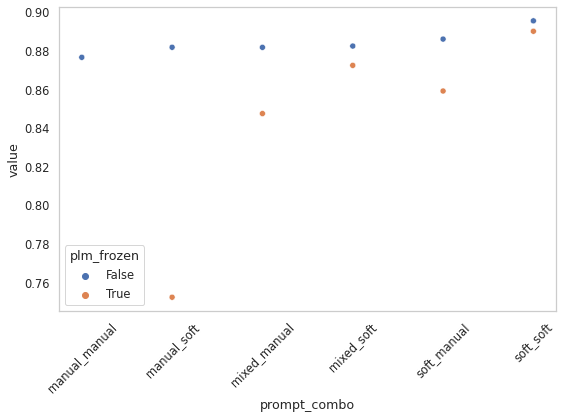

In [15]:
# Take a look at the triage task for all prompt combos used
prompt_combo_df = tb_data_processor.create_prompt_combination_data(produce_plot=True, metric = "balanced_accuracy", save = True)

## Look at some plots

### Finetuned PLM vs Frozen PLM 

In [43]:
# look at plot function - f1_weighted by default
# tb_data_processor.create_model_comparison_plot(mode = "valid", metric = "balanced_accuracy")

In [44]:
# test set
# tb_data_processor.create_model_comparison_plot(mode = "test")

### Prompt vs traditional classification

In [45]:
# tb_data_processor.create_model_comparison_plot(mode = "valid",plot_type = "prompt_vs_trad")

In [46]:
# tb_data_processor.create_model_comparison_plot(mode = "test",plot_type = "prompt_vs_trad")

### multi row plot

In [8]:
# grouped_tb_plot, tb_metrics = tb_data_processor.multi_row_plot(metric = "f1_weighted")

working on: valid
subsetting samples sizes: [16, 32, 64, 128, 150]
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_balanced_accuracy_baseline.csv


/home/niallt/venvs/3-7-NLP/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving created results files at: ./results/
subsetting samples sizes: [16, 32, 64, 128, 150]
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_auc_macro_baseline.csv


/home/niallt/venvs/3-7-NLP/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving created results files at: ./results/
subsetting samples sizes: [16, 32, 64, 128, 150]
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_f1_macro_baseline.csv


/home/niallt/venvs/3-7-NLP/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving created results files at: ./results/
subsetting samples sizes: [16, 32, 64, 128, 150]
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_f1_weighted_baseline.csv


/home/niallt/venvs/3-7-NLP/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving created results files at: ./results/
working on: test
subsetting samples sizes: [16, 32, 64, 128, 150]
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_balanced_accuracy_baseline.csv


/home/niallt/venvs/3-7-NLP/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving created results files at: ./results/
subsetting samples sizes: [16, 32, 64, 128, 150]
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_auc_macro_baseline.csv


/home/niallt/venvs/3-7-NLP/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving created results files at: ./results/
subsetting samples sizes: [16, 32, 64, 128, 150]
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_f1_macro_baseline.csv


/home/niallt/venvs/3-7-NLP/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving created results files at: ./results/
subsetting samples sizes: [16, 32, 64, 128, 150]
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_f1_weighted_baseline.csv


/home/niallt/venvs/3-7-NLP/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving created results files at: ./results/


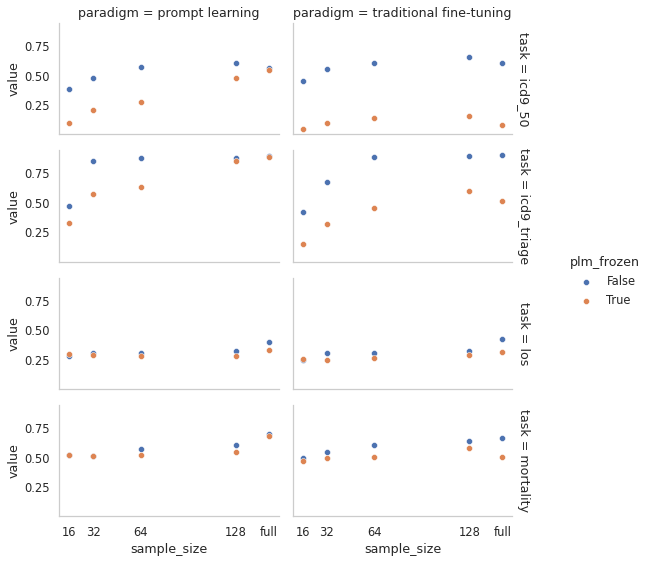

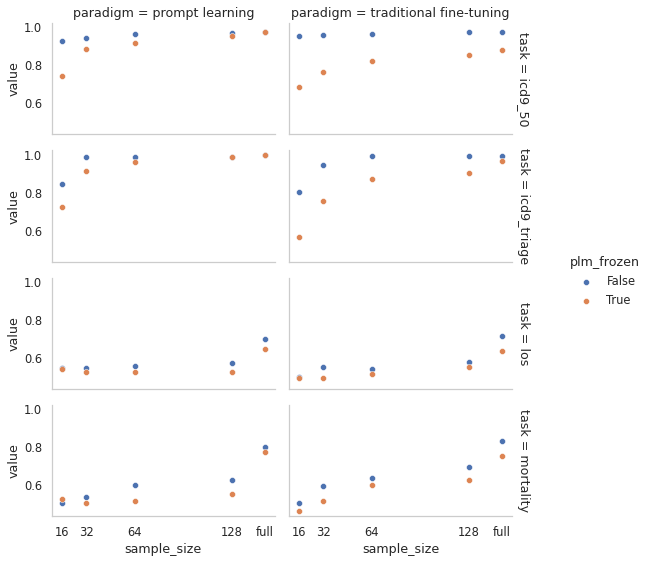

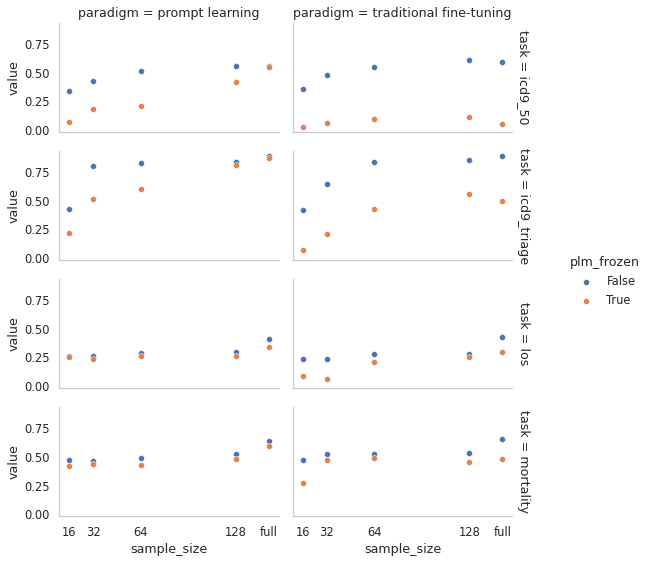

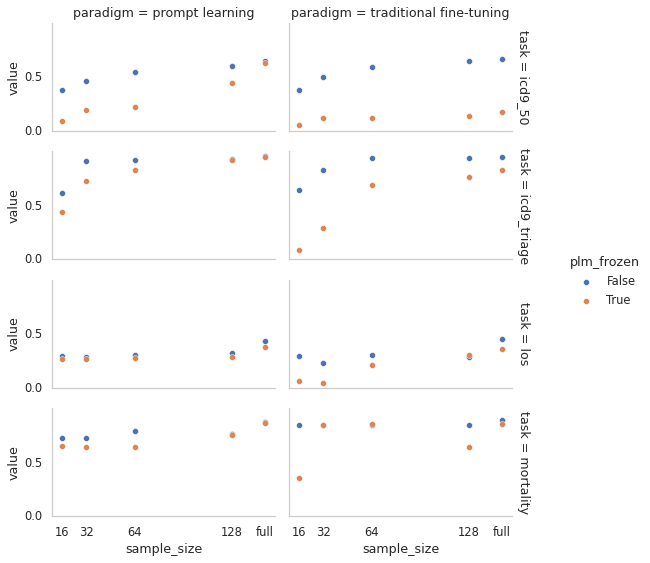

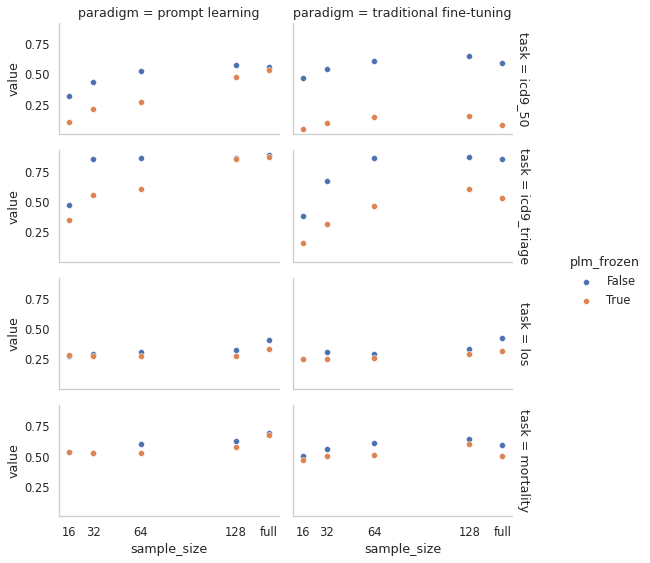

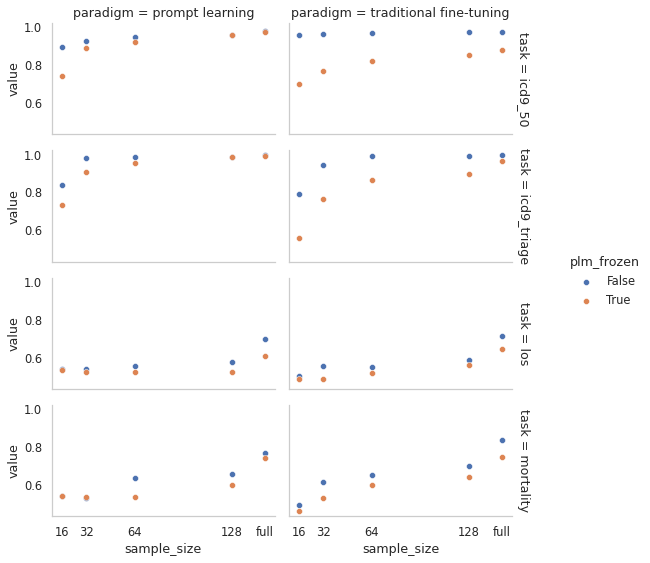

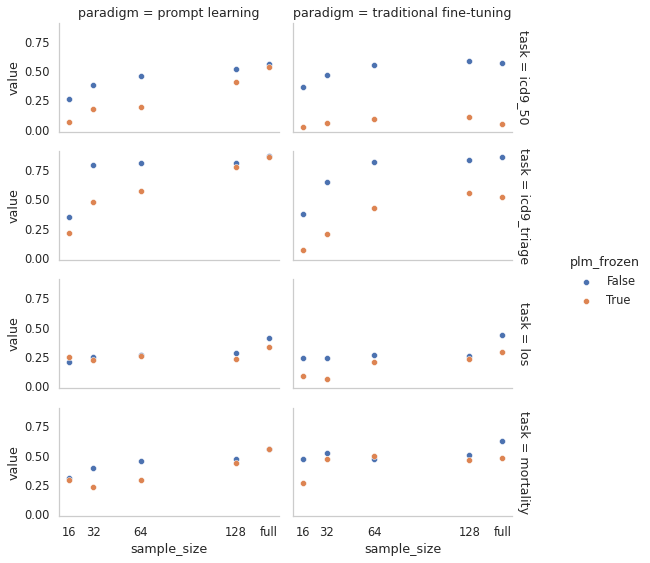

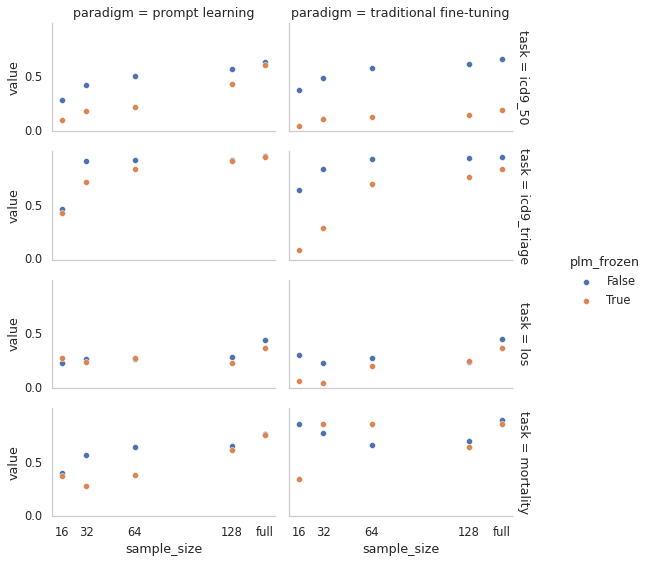

In [6]:
# Lets just produce all plots and save em in results

modes = ["valid","test"]
metrics = ["balanced_accuracy","auc_macro","f1_macro", "f1_weighted"]

for mode in modes:
    print(f"working on: {mode}")
    for metric in metrics:
        _, _ = tb_data_processor.multi_row_plot(mode = mode, metric = metric)
        

In [10]:
# grouped_tb_plot[grouped_tb_plot['task']=='los']

In [11]:
# tb_metrics[tb_metrics['task']=='los']

organising prompt model epoch training data for task: icd9_50
organising prompt model epoch training data for task: icd9_triage
organising prompt model epoch training data for task: mortality
organising prompt model epoch training data for task: icd9_50
organising prompt model epoch training data for task: icd9_triage
organising prompt model epoch training data for task: mortality
organising traditional model epoch training data for task: icd9_50
organising traditional model epoch training data for task: icd9_triage
organising traditional model epoch training data for task: mortality
organising traditional model epoch training data for task: icd9_50
organising traditional model epoch training data for task: icd9_triage
organising traditional model epoch training data for task: mortality


,index,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size
0,0,1,valid/f1_weighted,0.442533,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
1,1,2,valid/f1_weighted,0.572317,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
2,2,3,valid/f1_weighted,0.626895,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
3,3,4,valid/f1_weighted,0.618684,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
4,4,5,valid/f1_weighted,0.639007,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
...,...,...,...,...,...,...,...,...,...,...,...,...
64,9,10,valid/f1_weighted,0.844627,plm-classifier,mortality,30-03-2022--00-05-17,True,NaN,NaN,full,150
65,10,11,valid/f1_weighted,0.845022,plm-classifier,mortality,30-03-2022--00-05-17,True,NaN,NaN,full,150
66,11,12,valid/f1_weighted,0.845517,plm-classifier,mortality,30-03-2022--00-05-17,True,NaN,NaN,full,150
67,12,13,valid/f1_weighted,0.846011,plm-classifier,mortality,30-03-2022--00-05-17,True,NaN,NaN,full,150


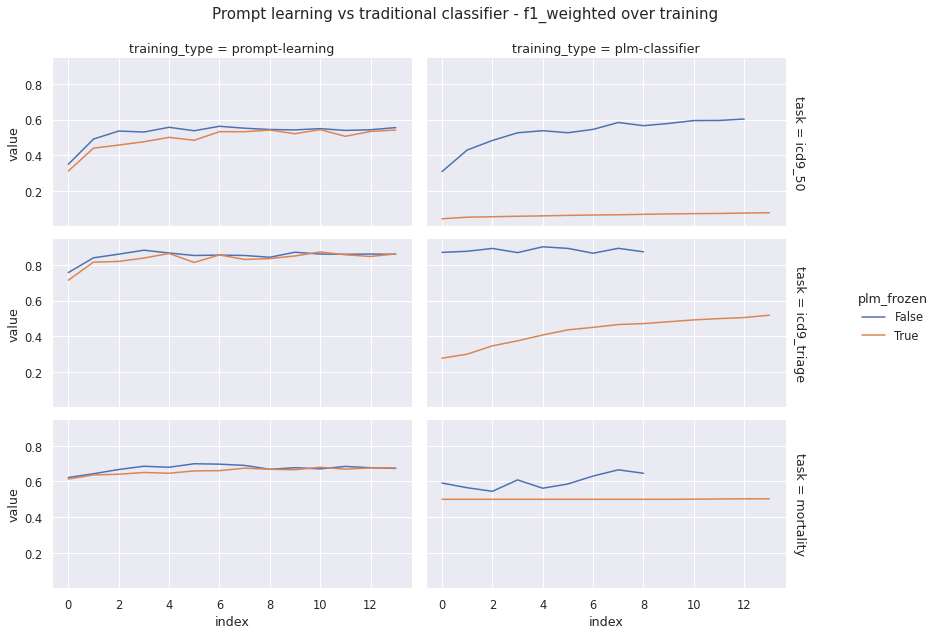

In [114]:
# epoch training plots

tb_data_processor.create_epoch_training_data()

# Sensitivity experiments
Here we wanted to investigate whether increasing or decreasing the number of trainable parameters would change the results in the favor of plm+classification head. Essentially the number of trainable paramters may be driving this entirely, so to directly compare prompt learning vs classification head performance on frozen PLMs, we can play around with the length of tunable prompts and the hidden dimension of classification heads

IMPORTANT - any of the prompt models with the old SoftVerbalizer will have an additional 625,000 trainable params. So only use the manual templates for now. Or the soft verbal with correctly frozen plm.

In [5]:
# # instantiate the TB_DataProcessor and provide log dir for the prompt based models
# tb_data_processor.sensitivity_logs

In [7]:

def run_sensitivity_analysis(tb_processor, modes=["test","valid"], groupby_list = ["paradigm","plm_frozen","task", "num_trainable_params"],
                            metrics = ["balanced_accuracy","f1_weighted","auc_macro"], save = True):
    # want to get few key metrics here: ["balanaced_accuracy","f1_weighted","auc_macro"]
    for mode in modes:
        print(f"working on mode: {mode}")
        for metric in tqdm(metrics):
            tb_sens_metrics = tb_data_processor.extract_metric(analysis = "sensitivity", mode = mode, metrics = metric)
            if mode =="valid":
                sens_plot_df = tb_sens_metrics[tb_sens_metrics['step']>0]
            else:
                sens_plot_df = tb_sens_metrics
            sens_plot_df.reset_index(inplace=True, drop = True)
            sens_plot_df

            # for soft verbalizer in its old form - we want toa dd 625000 to the num parameters trainable
            for idx, row in sens_plot_df.iterrows():
                if sens_plot_df.loc[idx]['verb_type'] == "soft":  
                    sens_plot_df.at[idx,'num_trainable_params'] = row['num_trainable_params'] + 625000
            
            # create grouped plot
            grouped_plot_df = sens_plot_df.groupby(groupby_list)["value"].max().to_frame().reset_index()

                        
            sns.scatterplot(x = 'num_trainable_params', y = 'value',
                            data = grouped_plot_df,                  
                            palette="bright",
                            hue = "paradigm")   


            # plt.suptitle(f"Comparing performance versus number of trainable parameters - {metric}")

            if save:
                # lets save this dataframe to the processors save_dir

                sens_plot_df.to_csv(f"{tb_data_processor.tables_dir}/sensitivity_analysis_triage_{mode}_{metric}.csv", index=None)

                grouped_plot_df.to_csv(f"{tb_data_processor.tables_dir}/grouped_sensitivity_analysis_triage_{mode}_{metric}.csv", index=None)

                # try all on one plot

                plt.savefig(f"{tb_data_processor.figures_dir}/sensitivity_plot_triage_{mode}_{metric}.pdf")
                plt.show()

working on mode: test


  0%|          | 0/3 [00:00<?, ?it/s]

Will be using sensitivity experiment logs
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_balanced_accuracy_sensitivity.csv


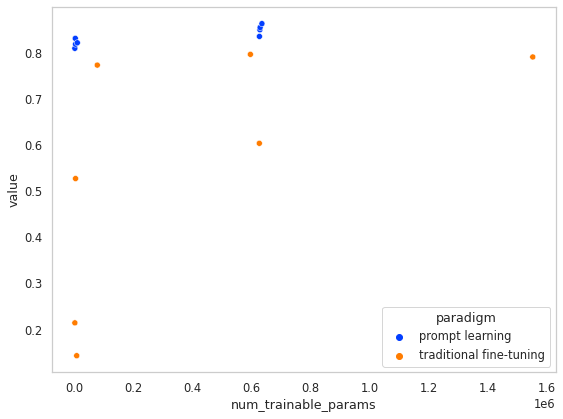

 33%|███▎      | 1/3 [00:00<00:00,  2.27it/s]

Will be using sensitivity experiment logs
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_f1_weighted_sensitivity.csv


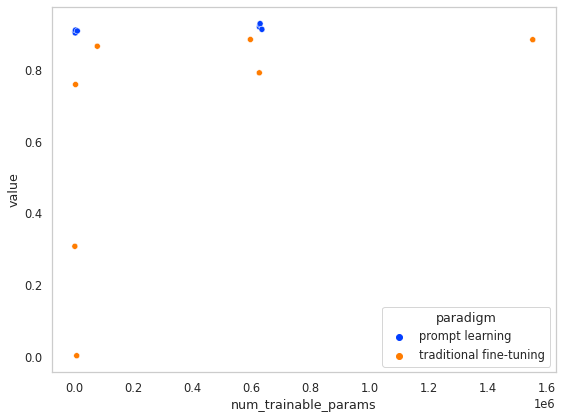

 67%|██████▋   | 2/3 [00:00<00:00,  2.45it/s]

Will be using sensitivity experiment logs
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_auc_macro_sensitivity.csv


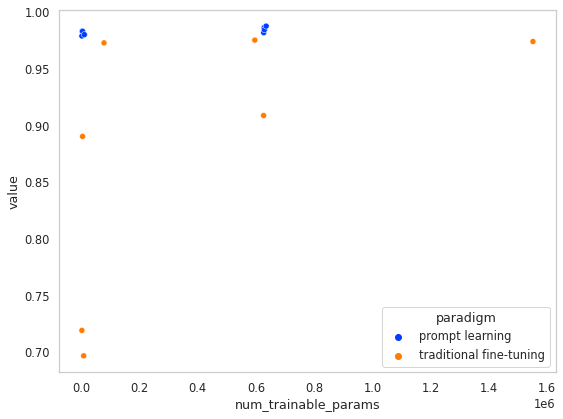

100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


working on mode: valid


  0%|          | 0/3 [00:00<?, ?it/s]

Will be using sensitivity experiment logs
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_balanced_accuracy_sensitivity.csv


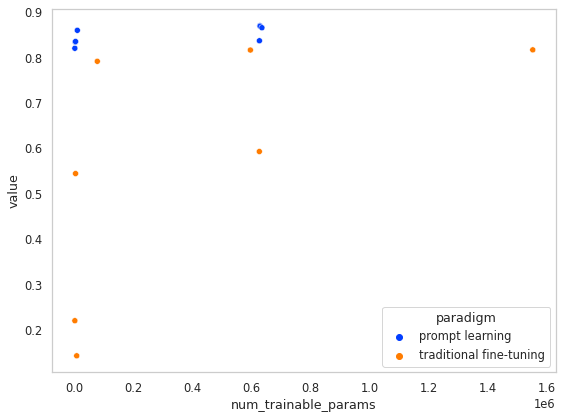

 33%|███▎      | 1/3 [00:00<00:00,  2.27it/s]

Will be using sensitivity experiment logs
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_f1_weighted_sensitivity.csv


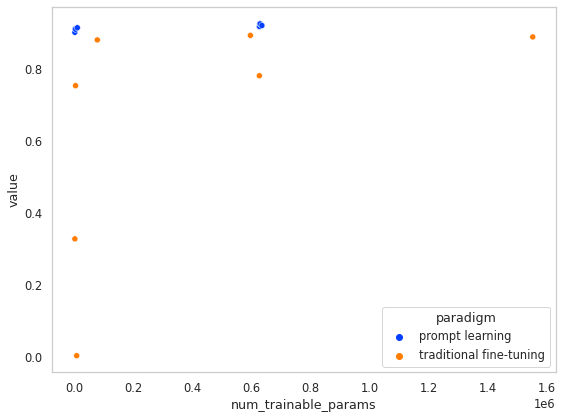

 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]

Will be using sensitivity experiment logs
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//valid_auc_macro_sensitivity.csv


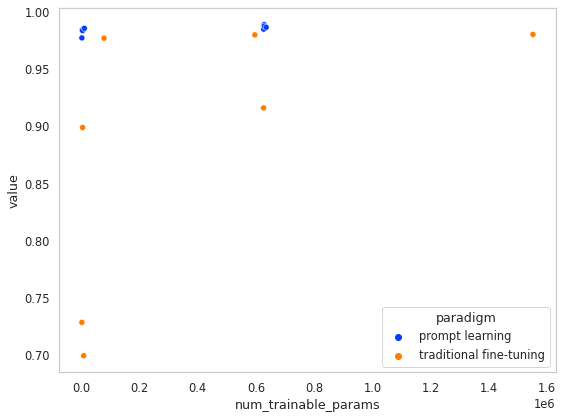

100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


In [8]:
run_sensitivity_analysis(tb_data_processor)

In [24]:
# sens_plot_df.head()

In [10]:
# for fairness - we want to just look at the mixed_template_manual_verbalizer - until we know more about the soft verbalizer issue. 

# sens_plot_df = sens_plot_df[(sens_plot_df['verb_type'] == "manual") | (sens_plot_df['verb_type'].isna()) ]
# sens_plot_df.verb_type.unique()

In [12]:
# groupby_list = ["paradigm","plm_frozen","task", "num_trainable_params"]

In [11]:
# grouped_plot_df = sens_plot_df.groupby(groupby_list)["value"].max().to_frame().reset_index()
# grouped_plot_df

In [13]:
# save this to file
# grouped_plot_df.to_csv(f"{tb_data_processor.tables_dir}/grouped_sensitivity_analysis.csv",index = None)

In [14]:

# # side by side plot perhaps
# prompt_sens_df = grouped_plot_df[grouped_plot_df['paradigm']=="prompt-learning"].reset_index(drop=True)
# plm_classifier_df = grouped_plot_df[grouped_plot_df['paradigm']=="plm-classifier"].reset_index(drop=True)


In [24]:


# # get the sample_sizes - as we want to customise these and use as xtick_labels       


# # side by side plot

# f, axes = plt.subplots(1, 2,sharey= True)

# sns.scatterplot(x = 'num_trainable_params', y = 'value',
#                 data = prompt_sens_df,                  
#                 palette="bright",
#                 ax=axes[0])
# # set title for 1st plot
# axes[0].set_title('prompt learning vs trainable params size')
# # set x ticks and labels


# sns.scatterplot(x = 'num_trainable_params', y = 'value',
#                 data = plm_classifier_df,                  
#                 palette="bright",
#                 ax=axes[1])      
# # set title for 2nd plot
# axes[1].set_title('traditional fine-tuning vs trainable params size')

# # plt.suptitle("Comparing performance versus number of trainable parameters")
# plt.savefig(f"{tb_data_processor.figures_dir}/sensitivity_plot.pdf")


In [25]:
# # try all on one plot

# sns.scatterplot(x = 'num_trainable_params', y = 'value',
#                 data = grouped_plot_df,                  
#                 palette="bright",
#                 hue = "paradigm")   


# # plt.suptitle("Comparing performance versus number of trainable parameters")
# plt.savefig(f"{tb_data_processor.figures_dir}/sensitivity_plot.pdf")

# Optimized parameter experiments
Here we choose ICD9 Triage task and found optimal hyperparamters for a given prompt model setup and plm+classification_head. We want to ensure that results were not entirely driven by poorly optimised models in the case of PLM+classifier in particular.

In [14]:
mode = "valid"
tb_opt_metrics = tb_data_processor.extract_metric(analysis = "optimized", mode = "test", metrics = "balanced_accuracy")
if mode =="valid":
    opt_plot_df = tb_opt_metrics[tb_opt_metrics['step']>0]
else:
    opt_plot_df = tb_opt_metrics
opt_plot_df.reset_index(inplace=True, drop = True)
opt_plot_df

Will be using optimized logs!
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_balanced_accuracy_optimized.csv


,step,tag,value,paradigm,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size,class_hidden_size,num_trainable_params
0,13,test/balanced_accuracy,0.783877,traditional fine-tuning,icd9_triage,08-04-2022--09-46-41,True,NaN,NaN,fewshot,128,768,595975
1,38,test/balanced_accuracy,0.784218,traditional fine-tuning,icd9_triage,08-04-2022--12-25-11,True,NaN,NaN,fewshot,128,768,595975


In [15]:
def run_optimized_analysis(tb_processor, modes=["test"], groupby_list = ["paradigm","plm_frozen","task", "num_trainable_params"],
                            metrics = ["balanced_accuracy","f1_weighted","auc_macro"], save = True):
    
    dfs = []
    for mode in modes:
        print(f"WORKING ON: {mode}")
        for metric in metrics:
            print(f"metric: {metric}")
            tb_opt_metrics = tb_data_processor.extract_metric(analysis = "optimized", mode = mode, metrics = metric)
            if mode =="valid":
                opt_plot_df = tb_opt_metrics[tb_opt_metrics['step']>0]
            else:
                opt_plot_df = tb_opt_metrics
            opt_plot_df.reset_index(inplace=True, drop = True)
            
            dfs.append(opt_plot_df)

    return dfs

In [16]:
opt_dfs = run_optimized_analysis(tb_data_processor)

WORKING ON: test
metric: balanced_accuracy
Will be using optimized logs!
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_balanced_accuracy_optimized.csv
metric: f1_weighted
Will be using optimized logs!
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_f1_weighted_optimized.csv
metric: auc_macro
Will be using optimized logs!
subsetting tasks : ['icd9_50', 'icd9_triage', 'mortality', 'los']
Saving metrics file file at: ./results//tables//test_auc_macro_optimized.csv


In [33]:
pd.concat(opt_dfs)

,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size,class_hidden_size,num_trainable_params
0,0,test/balanced_accuracy,0.849833,prompt-learning,icd9_triage,07-04-2022--15-25,True,mixed,soft,fewshot,128,768,3072
1,13,test/balanced_accuracy,0.783877,plm-classifier,icd9_triage,08-04-2022--09-46-41,True,NaN,NaN,fewshot,128,768,595975
2,38,test/balanced_accuracy,0.784218,plm-classifier,icd9_triage,08-04-2022--12-25-11,True,NaN,NaN,fewshot,128,768,595975
0,0,test/f1_weighted,0.904236,prompt-learning,icd9_triage,07-04-2022--15-25,True,mixed,soft,fewshot,128,768,3072
1,13,test/f1_weighted,0.878882,plm-classifier,icd9_triage,08-04-2022--09-46-41,True,NaN,NaN,fewshot,128,768,595975
2,38,test/f1_weighted,0.896059,plm-classifier,icd9_triage,08-04-2022--12-25-11,True,NaN,NaN,fewshot,128,768,595975
0,0,test/auc_macro,0.979223,prompt-learning,icd9_triage,07-04-2022--15-25,True,mixed,soft,fewshot,128,768,3072
1,13,test/roc_auc_macro,0.974425,plm-classifier,icd9_triage,08-04-2022--09-46-41,True,NaN,NaN,fewshot,128,768,595975
2,38,test/roc_auc_macro,0.978478,plm-classifier,icd9_triage,08-04-2022--12-25-11,True,NaN,NaN,fewshot,128,768,595975


# Below is just for testing a lot of code to go into classes - its ugly!

In [69]:
# look at all logs
tb_data_processor.all_logs.tag.unique()

array(['test/auc_macro', 'test/auc_weighted', 'test/balanced_accuracy',
       'test/f1_macro', 'test/f1_weighted', 'test/loss',
       'test/precision_macro', 'test/precision_weighted',
       'test/recall_macro', 'test/recall_weighted', 'train/batch_loss',
       'train/epoch_loss', 'valid/auc_macro', 'valid/auc_weighted',
       'valid/balanced_accuracy', 'valid/f1_macro', 'valid/f1_weighted',
       'valid/loss', 'valid/precision_macro', 'valid/precision_weighted',
       'valid/recall_macro', 'valid/recall_weighted',
       'zero_shot/auc_macro', 'zero_shot/auc_weighted',
       'zero_shot/balanced_accuracy', 'zero_shot/f1_macro',
       'zero_shot/f1_weighted', 'zero_shot/loss',
       'zero_shot/precision_macro', 'zero_shot/precision_weighted',
       'zero_shot/recall_macro', 'zero_shot/recall_weighted',
       'random/metric', 'valid/f1', 'valid/precision', 'valid/recall',
       'zero_shot/accuracy', 'zero_shot/f1', 'zero_shot/precision',
       'zero_shot/recall', 'epoch', '

In [5]:
# just look at f1
tb_metrics = tb_data_processor.extract_metric(mode = "valid", metrics = "f1_weighted")
tb_metrics

,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size
0,0,valid/f1_weighted,0.149462,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
1,1,valid/f1_weighted,0.504503,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
2,2,valid/f1_weighted,0.280483,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
3,3,valid/f1_weighted,0.544213,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
4,4,valid/f1_weighted,0.038835,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
...,...,...,...,...,...,...,...,...,...,...,...
1786,10,valid/f1_weighted,0.722053,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1787,11,valid/f1_weighted,0.733764,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1788,12,valid/f1_weighted,0.749319,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1789,13,valid/f1_weighted,0.752430,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500


In [87]:
# lets plot epoch vs f1_weighted or something

epoch_df = tb_metrics[tb_metrics["step"]>0]
epoch_df

,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size
1,1,valid/f1_weighted,0.504503,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
2,2,valid/f1_weighted,0.280483,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
3,3,valid/f1_weighted,0.544213,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
4,4,valid/f1_weighted,0.038835,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
5,5,valid/f1_weighted,0.272125,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
...,...,...,...,...,...,...,...,...,...,...,...
1487,10,valid/f1_weighted,0.722053,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1488,11,valid/f1_weighted,0.733764,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1489,12,valid/f1_weighted,0.749319,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1490,13,valid/f1_weighted,0.752430,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500


# we want to replicate some of the tensorboard training plots 

### start with just full training sets for task in following scenarios:

- prompt learning - mixed template and soft verb - the latest run - both frozen and not
- same as above but for plm+classification head


### then combine to allow on one plot

In [144]:
# sort by date perhaps
# first get the latest finetuned of each training type

prompt_finetune_df = epoch_df[(epoch_df["paradigm"]=="prompt learning") & 
                               (epoch_df["plm_frozen"]==False) & (epoch_df["task"]=="icd9_50") 
                              & (epoch_df["temp_type"]=="mixed") &
                              (epoch_df["training_size"]=="full")].reset_index(drop=True)
# get the date and i.e. the unique id for the run with the above setup that had best performance
max_value_prompt_finetuned_date = prompt_finetune_df.iloc[prompt_finetune_df['value'].idxmax()]['date']

prompt_finetune_plot_df = prompt_finetune_df.query('date == @max_value_prompt_finetuned_date')


In [148]:
prompt_finetune_plot_df

,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size
0,1,valid/f1_weighted,0.442533,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
1,2,valid/f1_weighted,0.572317,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
2,3,valid/f1_weighted,0.626895,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
3,4,valid/f1_weighted,0.618684,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
4,5,valid/f1_weighted,0.639007,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
5,6,valid/f1_weighted,0.629375,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
6,7,valid/f1_weighted,0.634158,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
7,8,valid/f1_weighted,0.631411,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
8,9,valid/f1_weighted,0.628334,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
9,10,valid/f1_weighted,0.615369,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150


<AxesSubplot:xlabel='step', ylabel='value'>

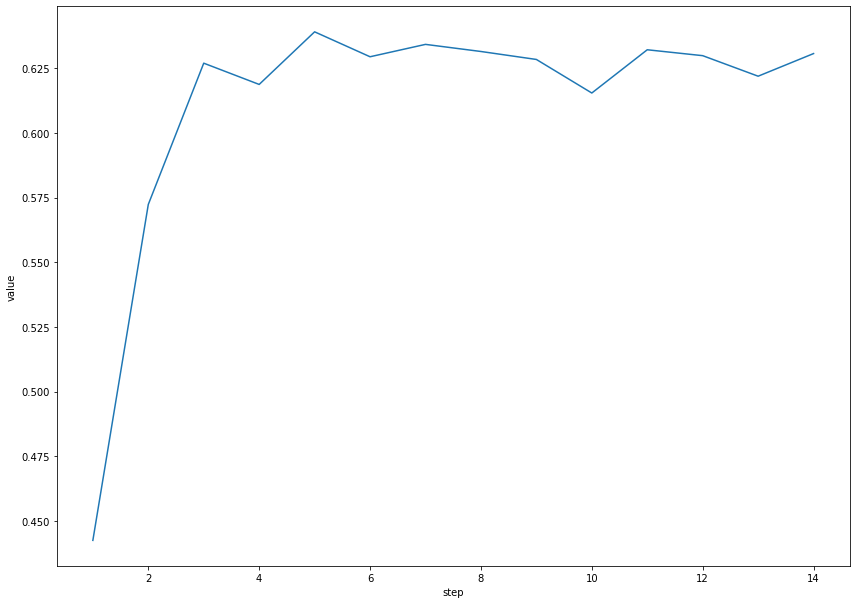

In [146]:
sns.lineplot(data = prompt_finetune_plot_df, x = 'step', y = 'value')

# now make a function of the above couple of cells for all scenarios

In [73]:
def create_epoch_training_data(tb_metrics, tasks = ['icd9_50','icd9_triage','mortality']):
    
    # we want to separately fill both prompt learning and traditional 
    prompt_dfs = []
    trad_dfs = []
    
    
    # first just get all metrics for all models and runs with a step or epoch value > 0 to avoid stupid results
    epoch_df = tb_metrics[tb_metrics["step"]>0]
    # go through the prompt task results and get the best performing training details    
    # run over both frozen and finetuned plm values - i.e. true/false
    for b in [False, True]:
        for t in tasks:         
            print(f"organising prompt model training data for task: {t}")

            # first get the latest finetuned of each training type

            prompt_df = epoch_df[(epoch_df["paradigm"]=="prompt learning") & 
                                           (epoch_df["plm_frozen"]==b) & (epoch_df["task"]==t) 
                                          & (epoch_df["temp_type"]=="mixed") &
                                          (epoch_df["training_size"]=="full")].reset_index(drop=True)
            # get the date and i.e. the unique id for the run with the above setup that had best performance
            max_value_prompt_date = prompt_df.iloc[prompt_df['value'].idxmax()]['date']

            # now get the data sharing this max value date
            prompt_best_df = prompt_df.query('date == @max_value_prompt_date')

            # append to all the prompt dfs
            prompt_dfs.append(prompt_best_df.reset_index(drop = True))
    # combine into one big prompt df
    all_prompt_df = pd.concat(prompt_dfs).reset_index()
    
    # now the plm+classification heads
    for b in [False, True]:
        for t in tasks:         
            print(f"organising traditional model data for task: {t}")

            # first get the latest finetuned of each training type

            trad_df = epoch_df[(epoch_df["paradigm"]=="traditional fine-tuning") & 
                                           (epoch_df["plm_frozen"]==b) & (epoch_df["task"]==t)&
                                          (epoch_df["training_size"]=="full")].reset_index(drop=True)
            # get the date and i.e. the unique id for the run with the above setup that had best performance
            max_value_trad_date = trad_df.iloc[trad_df['value'].idxmax()]['date']

            # now get the data sharing this max value date
            trad_best_df = trad_df.query('date == @max_value_trad_date')           
            
            # for a rookie mistake in the logging of loss in the pytorch lightning pipeline we want to 
            # derive the epoch/step number based on the indexes - so reset index here but drop it
            trad_dfs.append(trad_best_df.reset_index(drop = True))
    # combine all trad dfs
    all_trad_df = pd.concat(trad_dfs).reset_index()
    # now combine prompt and trad dfs
    all_df = pd.concat([all_prompt_df,all_trad_df])
#     g = sns.lineplot(data = all_prompt_df, x = 'step', y = 'value', hue = 'task')
    return all_df

In [82]:
# just look at f1
tb_metrics = tb_data_processor.extract_metric(mode = "valid", metrics = "balanced_accuracy")

epoch_training_df = create_epoch_training_data(tb_metrics)

organising prompt model training data for task: icd9_50
organising prompt model training data for task: icd9_triage
organising prompt model training data for task: mortality
organising prompt model training data for task: icd9_50
organising prompt model training data for task: icd9_triage
organising prompt model training data for task: mortality
all_prompt_df index col: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
organising traditional model data for task: icd9_50
organising traditional model data for task: icd9_triage
organising traditional model data for task: mortality
organising traditional model data for task: icd9_50
organising traditional model data for task: icd9_triage
organising traditional model data for task: mortality
all trad index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [83]:
epoch_training_df[epoch_training_df['task']=="icd9_50"]

,index,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size
0,0,1,valid/balanced_accuracy,0.349221,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
1,1,2,valid/balanced_accuracy,0.490758,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
2,2,3,valid/balanced_accuracy,0.535736,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
3,3,4,valid/balanced_accuracy,0.530135,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
4,4,5,valid/balanced_accuracy,0.556694,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
5,5,6,valid/balanced_accuracy,0.537439,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
6,6,7,valid/balanced_accuracy,0.562384,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
7,7,8,valid/balanced_accuracy,0.551585,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
8,8,9,valid/balanced_accuracy,0.544406,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150
9,9,10,valid/balanced_accuracy,0.542133,prompt-learning,icd9_50,18-03-2022--07-49,False,mixed,soft,full,150


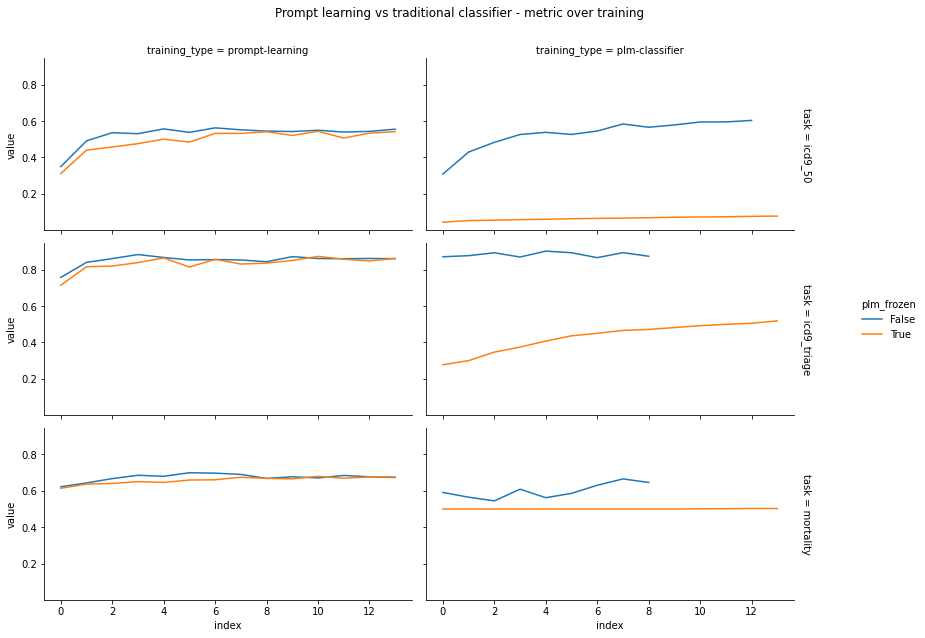

In [95]:
# epoch training plots


        
# seaborn facegrid plot

 # multi row plot
g = sns.FacetGrid(epoch_training_df,  col="paradigm",row = "task", hue = "plm_frozen",
                  aspect = 2, legend_out=True, margin_titles=True)
g.map(sns.lineplot, 'index', 'value')
g.add_legend()
g.tight_layout()
g.axes[0,0].set_xlabel('epochsdsds')
g.axes[0,1].set_xlabel('epoch')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Prompt learning vs traditional classifier - metric over training')
g.fig.show()

In [31]:
list(range(1,15))


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [30]:
a

range(1, 15)

In [168]:
for b in [True,False]:
    print(b)

True
False


In [6]:
# quick test of plot
# we don't really want metric from step 0 as this is often just development validation runs or zero shot
plot_df = tb_metrics[tb_metrics["step"]>0]


In [7]:
plot_df

,step,tag,value,training_type,task,date,plm_frozen,temp_type,verb_type,training_size,sample_size
1,1,valid/f1_weighted,0.504503,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
2,2,valid/f1_weighted,0.280483,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
3,3,valid/f1_weighted,0.544213,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
4,4,valid/f1_weighted,0.038835,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
5,5,valid/f1_weighted,0.272125,prompt-learning,mortality,29-03-2022--01-00,False,mixed,soft,fewshot,32
...,...,...,...,...,...,...,...,...,...,...,...
1452,10,valid/f1_weighted,0.722053,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1453,11,valid/f1_weighted,0.733764,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1454,12,valid/f1_weighted,0.749319,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500
1455,13,valid/f1_weighted,0.752430,plm-classifier,icd9_triage,21-03-2022--09-55-30,True,NaN,NaN,fewshot,500


In [8]:
# lets do some grouping for sensible plots
# groupby training type, task and frozen model

grouped_plot_df = plot_df.groupby(["paradigm","plm_frozen","task","sample_size"])["value"].max().to_frame().reset_index()
grouped_plot_df

,training_type,plm_frozen,task,sample_size,value
0,plm-classifier,False,icd9_50,150,0.662557
1,plm-classifier,False,icd9_50,200,0.621647
2,plm-classifier,False,icd9_50,500,0.654025
3,plm-classifier,False,icd9_triage,16,0.639942
4,plm-classifier,False,icd9_triage,32,0.804123
...,...,...,...,...,...
70,prompt-learning,True,mortality,64,0.635200
71,prompt-learning,True,mortality,128,0.749128
72,prompt-learning,True,mortality,150,0.863560
73,prompt-learning,True,mortality,200,0.621585


### first plot the fully finetuned models

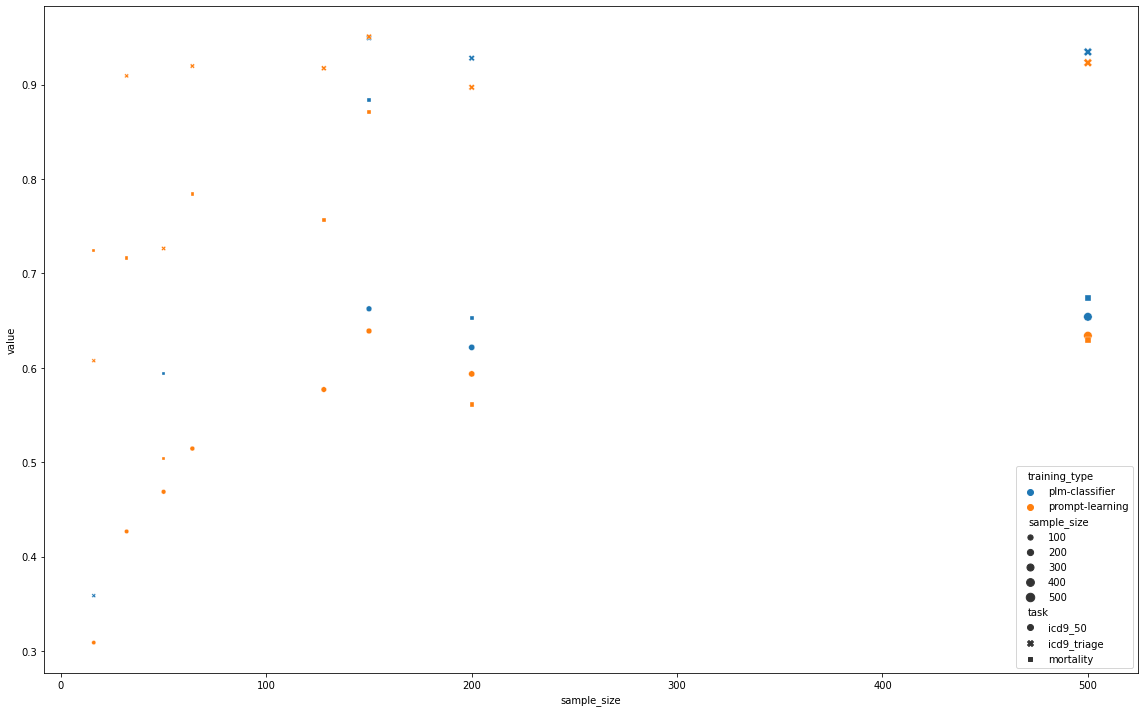

In [35]:

# extract just metrics with plm_frozen == False
finetuned_plot_df = grouped_plot_df[grouped_plot_df["plm_frozen"]==False]


plt.figure(figsize=(16,10))
g = sns.scatterplot(x = 'sample_size', y = 'value', data=finetuned_plot_df, hue='paradigm', style = 'task', size = 'sample_size')


plt.show()

### second plot the frozen plm models

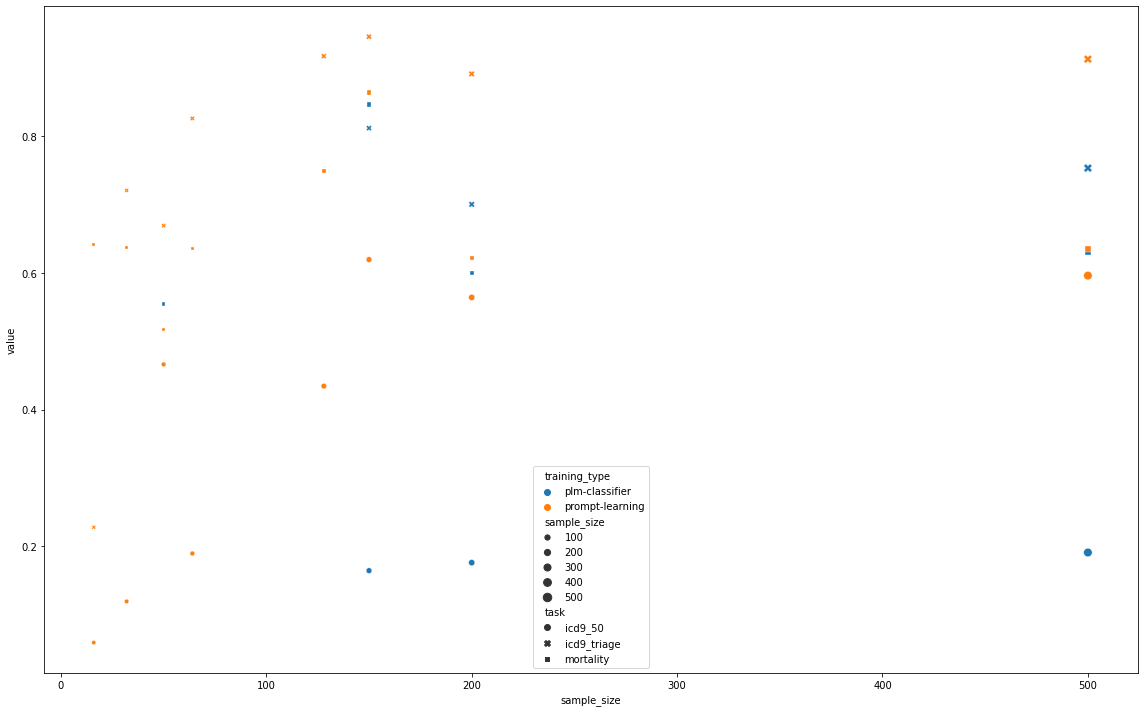

In [36]:
# extract just metrics with plm_frozen == False
frozen_plot_df = grouped_plot_df[grouped_plot_df["plm_frozen"]==True]


plt.figure(figsize=(16,10))
sns.scatterplot(x = 'sample_size', y = 'value', data=frozen_plot_df, hue='paradigm', style = 'task', size = 'sample_size')

plt.show()

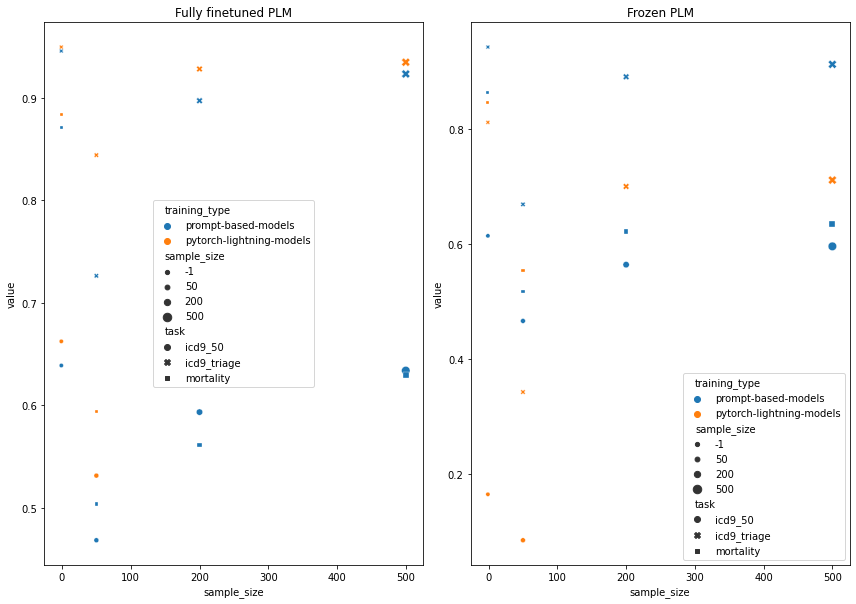

In [115]:
# try side by side plot

f, axes = plt.subplots(1, 2)

sns.scatterplot(x = 'sample_size', y = 'value',
                data=finetuned_plot_df, hue='paradigm', 
                style = 'task', size = 'sample_size', ax=axes[0])

axes[0].set_title('Fully finetuned PLM')

sns.scatterplot(x = 'sample_size', y = 'value',
                data=frozen_plot_df, hue='paradigm', 
                style = 'task', size = 'sample_size', ax=axes[1])

axes[1].set_title('Frozen PLM')
plt.show()

In [42]:
finetuned_plot_df.dtypes

training_type     object
plm_frozen          bool
task              object
sample_size        int64
value            float64
dtype: object

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (7).

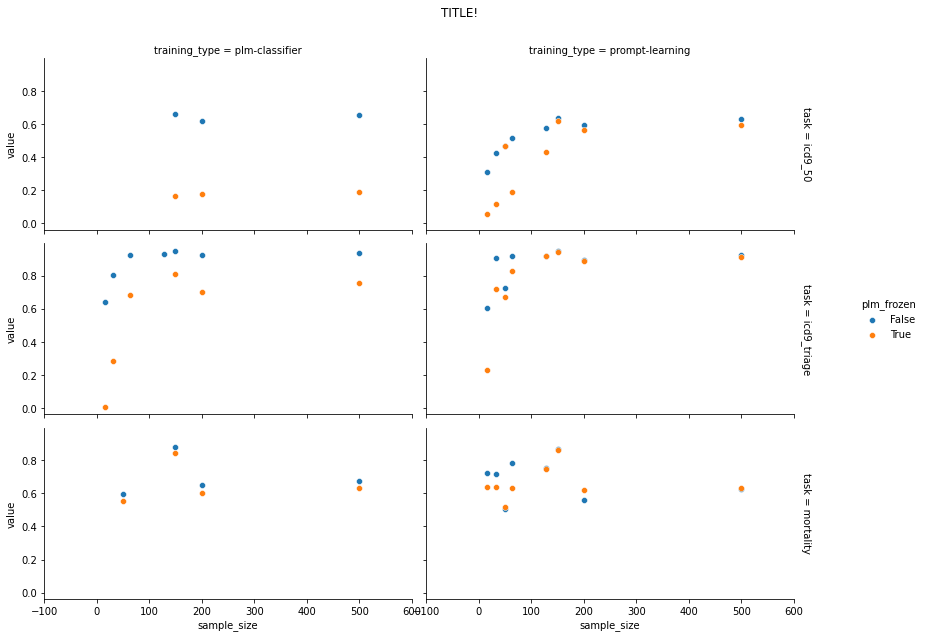

In [49]:
 # multi row plot
    
g = sns.FacetGrid(grouped_plot_df,  col="paradigm",row = "task", hue = "plm_frozen",
                  aspect = 2, legend_out=True, margin_titles=True)
g.map(sns.scatterplot, 'sample_size', 'value')
g.add_legend()
g.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('TITLE!')
g.set(xticks = )
g.set_xticklabels([11,22,33,44,55,77,88])
g.fig.show()


In [ ]:
# training over epoch plots


In [32]:
grouped_plot_df

,training_type,plm_frozen,task,sample_size,value
0,plm-classifier,False,icd9_50,150,0.662557
1,plm-classifier,False,icd9_50,200,0.621647
2,plm-classifier,False,icd9_50,500,0.654025
3,plm-classifier,False,icd9_triage,16,0.358604
4,plm-classifier,False,icd9_triage,150,0.949478
...,...,...,...,...,...
64,prompt-learning,True,mortality,64,0.635200
65,prompt-learning,True,mortality,128,0.749128
66,prompt-learning,True,mortality,150,0.863560
67,prompt-learning,True,mortality,200,0.621585


In [31]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [64]:
tb_metrics.groupby(["verb_type","temp_type"])["value"].max()

verb_type  temp_type
manual     manual       0.946914
           mixed        0.948727
           soft         0.949100
soft       manual       0.949605
           mixed        0.949256
           soft         0.946888
Name: value, dtype: float64

In [ ]:

plt.figure(figsize=(16,10))
sns.scatterplot(x = 'sample_size', y = 'value', data=plot_df, hue='paradigm', style = 'task', size = 'sample_size')

plt.show()

In [ ]:
# prompt_metrics[(prompt_metrics["temp_type"]=="soft") &(prompt_metrics["verb_type"]=="soft")]

In [3]:
# log_dir = "../prompt-based-models/logs/"
# log_dir = "../pytorch-lightning-models/logs/"

pytorch lightning and more manual approaches used in prompt learning save the hyperparameters differently. Need to check both can be read in
          
 
           

In [2]:
# test reader for the pytorch lightning models

# log_dir = "../prompt-based-models/logs/mortality/emilyalsentzer/Bio_ClinicalBERT_tempmixed2_verbsoft0_fewshot_200/version_17-03-2022--14-43/"
# reader = SummaryReader(log_dir)

# reader.scalars
# reader.hparams

In [4]:
# test reader for the pytorch lightning models

# log_dir = "../pytorch-lightning-models/logs/mortality/emilyalsentzer/Bio_ClinicalBERT/version_02-03-2022--11-52-19/"
# reader = SummaryReader(log_dir)

# reader.scalars
# reader.hparams